#### includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load
import torch
import sys



In [3]:
import sources
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils.clip_pad import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from src.trainer import BinaryClassifierNet
from sources import load_dataset, parse_config, setup_model

### Cos Sin Combination Test

In [4]:
alpha = torch.linspace(0, 2*np.pi, 4)
k_max = 5
kalpha = torch.stack([k*alpha for k in range(1,k_max+1)])
true_cos_sin_kalpha = torch.stack([torch.cos(kalpha), torch.sin(kalpha)])

In [12]:
from steered_cnn.steered_conv.steerable_filters import cos_sin_ka, cos_sin_ka_stack
fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha), torch.sin(alpha), k_max)
diff = true_cos_sin_kalpha-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'cos':diff[0].mean(-1), 'sin': diff[0].mean(-1)}, index=list(range(1,k_max+1)))

Average Diff:


,cos,sin
1,0.000000e+00,0.000000e+00
2,-7.450581e-09,-7.450581e-09
3,1.490116e-08,1.490116e-08
4,2.235174e-08,2.235174e-08
5,5.960464e-08,5.960464e-08


**Not Unary cos sin**

In [11]:
fast_cos_sin_kalpha = cos_sin_ka_stack(torch.cos(alpha)*3, torch.sin(alpha)*3, k_max)
diff = true_cos_sin_kalpha*3-fast_cos_sin_kalpha
print('Average Diff:')
pd.DataFrame({'cos':diff[0].mean(-1), 'sin': diff[0].mean(-1)}, index=list(range(1,k_max+1)))

Average Diff:


,cos,sin
1,0.000000e+00,0.000000e+00
2,-5.960464e-08,-5.960464e-08
3,0.000000e+00,0.000000e+00
4,1.788139e-07,1.788139e-07
5,1.192093e-07,1.192093e-07


### Steerable Test

In [24]:

base = SteerableKernelBase.create_from_rk(4)
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = x+y
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}

W = base.approximate_weights(K, info)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')

torch.set_printoptions(precision=3, sci_mode=False)
print(W)


mse:0.017, r2:0.992
tensor([[[     0.000,     -0.000,      0.000,      0.000,      0.290,
               1.863,      1.154,     -0.000,      0.000,      0.000,
               0.383,     -0.827,     -0.000,      0.000,      0.067,
              -0.741,      0.000,      0.230,     -0.000,      0.290,
               1.863,      1.154,     -0.000,      0.000,     -0.000,
              -0.383,      0.827,     -0.000,      0.000,      0.067,
              -0.741,     -0.000,     -0.230,     -0.000]]])


**Checking weight approximation**

mse:0.017, r2:0.992


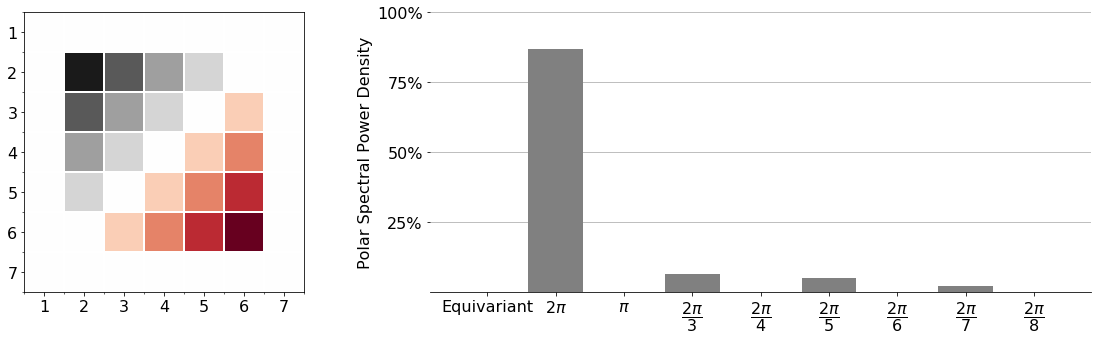

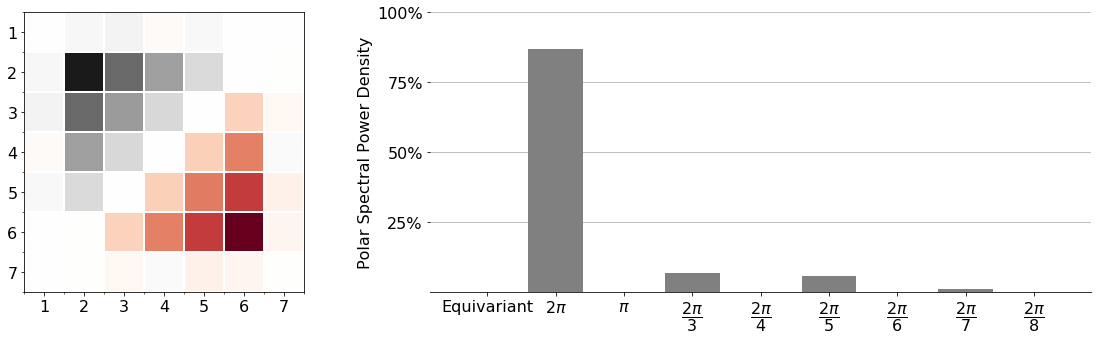

In [30]:
plot_filter(K[0,0], spd=True)
plot_filter(info['y_approx'][0,0], spd=True)
print(f'mse:{info["mse"]:.3f}, r2:{info["r2"]:.3f}')


**Checking filter rotation for different steer angle $\alpha$**

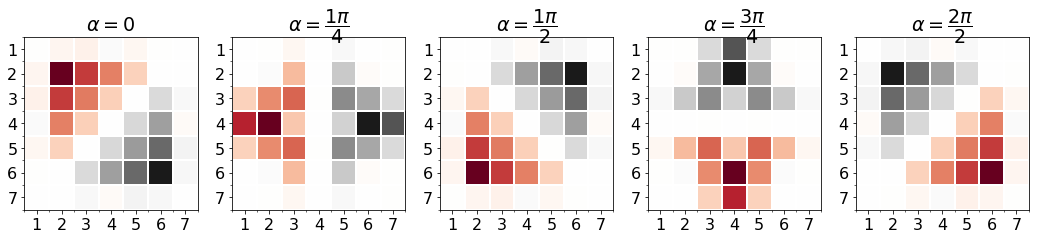

In [31]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,5)
N = len(axs)-1
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
for i in range(N+1):
    plot_filter(base.conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i])
    if i==0:
        axs[i].set_title('$\\alpha=0$')
    elif i%2 or N%2:
        axs[i].set_title('$\\alpha = \dfrac{%i \pi}{%i}$' % (i, N))
    else:
        axs[i].set_title('$\\alpha = \dfrac{%i \pi}{%i}$' % (i//2, N/2))